# Text Classification

**Level:** High. Using a library. Primarily conceptual, not coding.

These notes are based on the text classifier tutorial from the [fast.ai documentation](https://docs.fast.ai/tutorial.text.html), the NLP lesson from the [fast.ai course](https://course.fast.ai/Lessons/lesson4.html) and Chapter 10 of the [fast.ai book](https://github.com/fastai/fastbook/tree/master).

## Sections in this Notebook
1. [Fit a Model](#scrollTo=G4CbUp81BrXj&line=1&uniqifier=1)
2. [Transfer Learning and Language Models](#scrollTo=k4oYW0Q0QR5p&line=1&uniqifier=1)
2. [Text Tokenization, Numericalization, and Embedding](#scrollTo=unvYKz53QbdK&line=1&uniqifier=1)
3. [LSTM and Transformers](#scrollTo=1gni3DsX3_XG&line=1&uniqifier=1)

## Vocab Terms

* **inflection.** The way a word is altered based on verb tense, whether it is plural, its case in a sentence, and so on.

* **Language Model.** A model which evaluates the probability of a given text. These can be used to generate additional text given a prompt (like ChatGPT or GPT3), or can be used for transfer learning.

* **LSTM.** Long-term short-term memory, a type of neural network used for sequence data (like text). The LSTM architecture is a specific example of a recurrent neural network (RNN).

* **NLP.** Natural language processing. Working with text with machines.

* **Numericalization.** Conversion of tokens into numbers. These are then used as look-ups for an embedding, just like we did with recommender systems.

* **RNN.** Recurrent neural network. A type of neural network in which outputs are fed back into the network along with the next set of inputs. Also useful for time series data: the previous result is used to predict the next one.

* **sentiment analysis.** A specific type of classification where the goal is to determine the positivity or negativity of a statement. Can also include ratings 1-5 or more general labels. There's no difference in how the analysis is performed from a more general classification task.

* **Tokenization.** Splitting of strings into individual pieces, called tokens. Tokens will often be words or punctuation, but can also be sub-words or individual characters, depending on the tokenization method and language used.

* **Transformers.** A type of neural network used for sequence data (like text). It uses a technique called self-attention to determine which words are the most important to determining the output.

* **ULMFiT.** A type of transfer learning where an LSTM language model is first fine-tuned on the target text source (i.e. review texts) and then later trained for classification.

## Fit a Model

The details of language models are complex, and we'll eventually get to how LSTM language models work in this course (in Notebook 8). But let's just jump in and fit a classification model to some simple data using fast.ai.

We'll look at some [spam text messages](http://ai.stanford.edu/~amaas/data/sentiment/). Our goal is to determine whether each entry is a spam message or not.

The code below should look mostly familiar:
* Load library
* Get dataset
* Inspect it
* Put data into a dataloaders
* Download a pretrained model
* Fine-tune it and evaluate model

In [ ]:
from fastai.text.all import *

In [ ]:
!wget https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip
!unzip sms+spam+collection.zip

--2024-10-28 13:06:39--  https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘sms+spam+collection.zip’

sms+spam+collection     [ <=>                ] 198.65K  --.-KB/s    in 0.03s   

2024-10-28 13:06:39 (6.33 MB/s) - ‘sms+spam+collection.zip’ saved [203415]

Archive:  sms+spam+collection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


In [ ]:
spam = pd.read_csv("SMSSpamCollection", sep="\t", names=["y", "text"])
spam.head(2)

,y,text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...


In [ ]:
dls = TextDataLoaders.from_df(spam, text_col="text", label_col="y")

In [ ]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

/usr/local/lib/python3.10/dist-packages/fastai/text/learner.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  wgts = torch.load(wgts_fname, map_location = lambda storage

In [ ]:
learn.fine_tune(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.514716,0.126411,0.971275,00:15


epoch,train_loss,valid_loss,accuracy,time
0,0.181917,0.056612,0.986535,00:11


When I run this, I get accuracies $\geq99\%$. Not bad! This process (and the AWD-LSTM model) does quite well on a variety of classification tasks.

You'll notice that it is quite slow to train. With only 5000 in the entire dataset, it still takes several minutes to train, longer than some of our very large image datasets. This is a persistent issue with text analysis neural networks, which we'll get into the details of later in the course.

## Transfer Learning and Language Models

With image classification, we used *transfer learning*, that is, we loaded in a pre-trained model, then made tweaks to it in order to work on new classes of images. We didn't use transfer learning for either tabular data or our recommender systems.

Why not? Because each of those systems is unique: in what sense is one table of data so similar to another that a correct prediction can be just a few tweaks away? And is there any reason to believe one recommendation's user and item IDs map to another's? No.

Language models are more like vision models, in that there is a lot that can be re-used. A language model needs to, in some sense, be able to process the English language. There's a much larger difference between random text and coherent English than there is between classifying reviews positive/negative and generating new text. So, transfer learning is viable.

But there is some subtlety: most language models are language-specific. Adjusting an English-language model to work in Spanish is more than a simple fine-tuning can account for, even though the languages have some similarity.

## Text Tokenization, Numericalization, and Embedding

As with categorical data, images, and recommendation systems, we must first convert text data into a useful numeric format. This is done in three stages:

1. **Tokenization.** Every text is made up of smaller pieces. Tokenization is the process of breaking it down into *tokens*. In English, tokens are often individual words, but not always.
2. **Numericalization.** Convert each token into an ID number, that will be used to look up an embedding. The mapping between tokens and numbers is called a *vocabulary*. At this point, the data can be loaded into the model.
3. **Embedding.** Convert each number into a vector, using an embedding layer, just as we did for the recommender system. This is done in the neural network itself.

We already know how to do steps 2 and 3, so let's look more deeply at tokenization.


### Tokenization

There are three broad approaches to tokenization and building of a vocabulary for a language model:

1. **Word tokenization.** Split text into individual words. The vocabulary is just a set of words. Vocabularies always have a maximum size, and so only the most common words get stored in the vocabulary.
3. **Character tokenization.** Split text into individual characters. Each character would then be an entry in the vocabulary.
2. **Subword tokenization.** Split text into pieces of words, based on how common those pieces of words are. Each entry in the vocabulary will either be a word or a piece of a word, like "-n't", "anti-", or "bagel". (Often the best)

___
EX: Tokenization of the word "Personification" would split it into individual pieces of meaning...

Person (Noun)/ify(becomes a verb)/cation(becomes something else)

EX: "I like cats, but cats don't like me

Word Tokenization: Vocab (words):
I
like
Cats
but
don't
me

Character Tokenization: Vocab(letters)
I
l
k
e
c
...

Subword Tokenization: Vocab(Common aspects)
The letter S is common to show pluralness, so this might be one

n't from don't
___
Let's take a look at what the default fast.ai tokenizer does before considering others. If we look at one batch of our dataset, we see:

In [ ]:
dls.show_batch(max_n = 2)

,text,category
0,"xxbos xxmaj sad story of a xxmaj man - xxmaj last week was my b'day . xxmaj my xxmaj wife did'nt wish me . xxmaj my xxmaj parents forgot n so did my xxmaj kids . i went to work . xxmaj even my xxmaj colleagues did not wish . xxmaj as i entered my cabin my xxup pa said , '' xxmaj happy xxmaj b'day xxmaj boss ! ! '' . i felt special . xxmaj she askd me 4 lunch . xxmaj after lunch she invited me to her apartment . xxmaj we went there . xxmaj she said , '' do u mind if i go into the bedroom for a minute ? '' '' ok '' , i sed in a sexy mood . xxmaj she came out 5 minuts latr wid a cake … n xxmaj my xxmaj wife , xxmaj my xxmaj parents ,",ham
1,"xxbos xxmaj sad story of a xxmaj man - xxmaj last week was my b'day . xxmaj my xxmaj wife did'nt wish me . xxmaj my xxmaj parents forgot n so did my xxmaj kids . i went to work . xxmaj even my xxmaj colleagues did not wish . xxmaj as i entered my cabin my xxup pa said , '' xxmaj happy xxmaj b'day xxmaj boss ! ! '' . i felt special . xxmaj she askd me 4 lunch . xxmaj after lunch she invited me to her apartment . xxmaj we went there . xxmaj she said , '' do u mind if i go into the bedroom for a minute ? '' '' ok '' , i sed in a sexy mood . xxmaj she came out 5 minuts latr wid a cake … n xxmaj my xxmaj wife , xxmaj my xxmaj parents ,",ham


Some things you may notice:

* At first glance, this looks like word tokenization, but there are some subwords, for example contractions like `n't`.
* Punctuation marks are kept as separate tokens, unless they are inside of words. At least one special multi-punctuation token: `...`
* All tokens are lowercase, but case has been indicated by special tokens `xxmaj` and `xxup`.
* Special tokens indicating the beginning and end of the text (or "stream"): `xxbos` and `xxeos`.
* Special token for any word not in the vocabulary: `xxunk`

We can also see the result of numericalization in the dataloaders. As mentioned above, this is the format that is fed into the network:


In [ ]:
dls.one_batch()

(TensorText([[   2,    8,  618,  ..., 1343,   17,   18],
             [   2,    8,   27,  ...,    1,    1,    1],
             [   2,    8, 2242,  ...,    1,    1,    1],
             ...,
             [   1,    1,    1,  ...,    1,    1,    1],
             [   1,    1,    1,  ...,    1,    1,    1],
             [   1,    1,    1,  ...,    1,    1,    1]], device='cuda:0'),
 TensorCategory([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
                 1], device='cuda:0'))

What are the advantages of each of the three approaches to tokenization?

##### **Word Tokenization**
This is how most English speakers think of text, as a sequence of words, and so the vocabulary for our texts will fit that intuition.

The downside is that this method potentially requires a very large vocabulary, or we will end up with a lot of "unknown" tokens.

##### **Character Tokenization**
If your vocabulary contains are all English characters and punctuation, then every word can be represented in a very small vocabulary: ignoring punctuation, it's only 26 tokens.

What's the problem, then? This vocabulary is too small. Our embedding learns a meaning for each token, but each letter will need to take into account each word that can be built out of it, to varying degrees. That's not feasible.

##### **Subword Tokenization**
This method tends to be a good compromise between the two. Subword tokenization starts with the set of the language's characters (26 for English) and builds up a vocabulary using the example text by combining pairs of tokens to produce new tokens. Two tokens can be combined to create a new one if the combination is very frequent (see homework problem).

Because the starting token set is the language's characters, we're guaranteed to have every word be buildable in the vocabulary. And, with reasonably large maximum vocabulary size, you will see common words, along with prefixes and suffixes.

These can have their individual meanings learned by the neural network and combined. For example we'll almost certainly have the "-ly" suffix in our vocabulary, which means "convert this word from an adjective to an adverb."

### Aside: Anglocentrism

The discussion so far has assumed that we are working with English texts, and left other languages as a "find a different pre-trained model" issue. But by doing so, I've neglected many considerations. What follows are some problems when trying to apply these concepts to other languages (at least, ones I have some knowledge of).

##### **What's a word?**

English signals the end of one word and the beginning of the next with spaces or punctuation. But that's not the case in every language:

* Chinese, Japanese, classical Latin and Greek *do not* contain spaces. You cannot simply split them in that way.
* English has very little **inflection**, primarily in plurals (dog vs. dogs), which means that you can count "I walk" and "you walk" as the same, but in a language like Spanish, the first person and second person version of the verb "camino" and "caminas" are not the same and must be learned separately.
* Prior to the printing press, most languages did not all have standardized spelling, so finding two of the same word is more complex than seeing if all of its characters are the same.

##### **What's a character?**

* English has uppercase and lowercase, but not every language does.
* Even languages which do contain cased letters (e.g. Attic Greek) do not assign meaning the same way to cases.
* Position within a word can change how characters are written: in Greek, when a lowercase sigma "σ" ends a word, it is written as "ς". This character is also a sigma. English has historically had these kinds of characters, like the [long and short "s"](https://library.csun.edu/SCA/Peek-in-the-Stacks/esses) in "ſucceſs", and still contains more subtle ligatures, like in the word "final."
* Japanese has three different character sets, two of which are approximately syllables. The hiragana `ふ` and katakana `フ` are both pronounced "fu", but are not interchangeable. But, words that normally are written in hiragana can be written in katakana. I would describe this very rough rule as when you want to write in ALL CAPS or *in italics*, you can just use katakana. Should we convert everything to hiragana and add a `xxkatakana` token?
* Many languages add diacritics to letters, which alter their pronunciation or meaning of words. Spanish uses acute accent marks ("tú" and "tu" are different words pronounced identically), languages also include diaresis (as in "naïve"), circumflexes (as in "crêpe"), and so on. Should we count "ú" and "u" as the same letter? Perhaps we should decompose it into two: "xxacute" and "u"?
* Hebrew is even more fun: Hebrew *can* add nikkud diacritics to letters to specify the vowel: "ב" is read as "v" while "בָ" is read as "va". *But* these nikkud are only omnipresent in Masoretic Hebrew texts, while they are not present in Ancient Hebrew (they were an intentional later invention), and are almost always omitted in Modern Hebrew but are sometimes included for clarity of pronunciation. It's actually even more complicated than this brief explanation.



## LSTM and Transformers

At this point, almost all natural language processing models are transformer architectures, like GPT-3, ChatGPT, and transformer derivatives like BERT, DeBERTa and many other similar models. Here's [a variety of models](https://huggingface.co/models?pipeline_tag=text-classification&sort=trending) available through the huggingface repositories. Here is a link to the [notebook on using transformers](https://colab.research.google.com/drive/11TPgUddMj8eFoZKI3nEUlf8gwhoJfqlr?usp=drive_link) from your instructor's text analysis course. Understanding how long-term short-term memory (LSTM) and the recurrent neural network (RNN) architectures work will be covered in a later part of the course. For now, this brief interlude must suffice.

So far in this course, we've looked at *feed-forward networks*. These networks take in some x values and return a $\hat{y}$ (or multiple $\hat{y}$s). There is a clear flow of data from the beginning to the end, with no loops. An RNN takes in the previous $\hat{y}$ as an additional input alon with the xs, creating a feedback loop. Here's a diagram, including showing an "unrolling" (image from [Dive into Deep Learning](https://d2l.ai/chapter_recurrent-neural-networks/)):

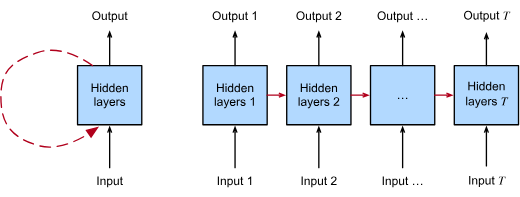

The hidden layer takes an input, does *something* to it (transformation, neural network change, whatever), then uses those changes along with another input in the next neural layer, and you do it again and again and again.

Each output is what the user gets to see

By contrast, a transformer takes in multiple tokens simultaneously. Its primary breakthrough is the idea of using self-attention, in which the network learns which words are the most important to understanding other words within the input. For example, in the sentence "Sandra has a large collection of records which she loves," we know that to understand "she" we need to identify its antedecent as "Sandra," and not the other noun in the sentence, "collection." Below is an image showing attention during a translation task. You can see that words in the output need information about words at a different position in the input, as French orders adjectives differently from English (Image [from this paper](https://arxiv.org/pdf/1409.0473.pdf)).

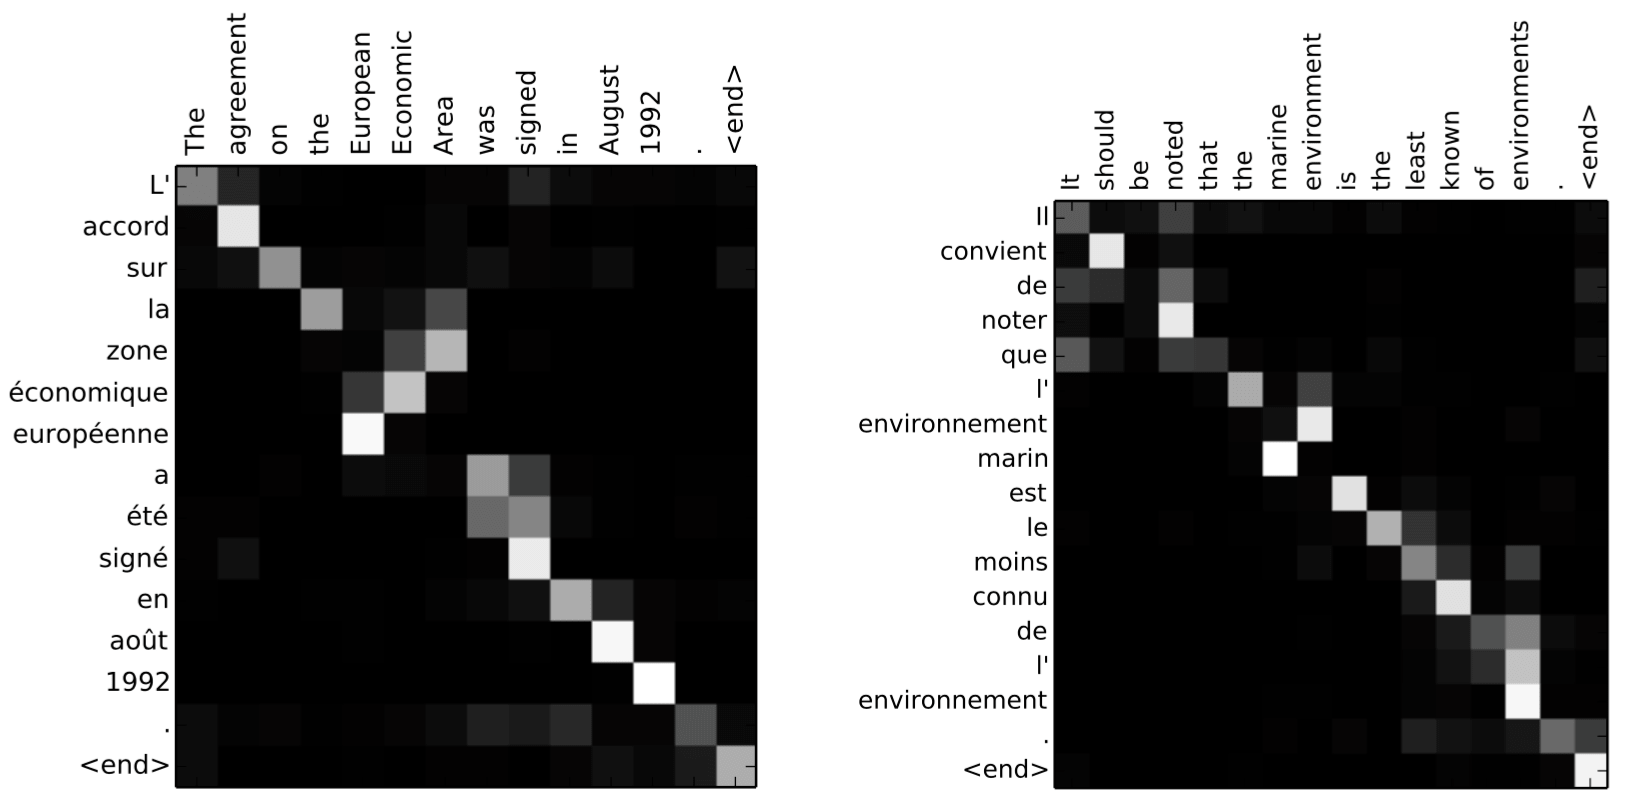

#### Advantages of Transformers

* Transformers typically out-perform RNNs for tasks requiring sequence output: for example, translation, summarization, and chatbots. This is because an RNN must get all of its data *in order* and either produce output as it goes along (and not look ahead), or try and store its entire understanding of the task in its hidden layer nodes, while a transformer can look at the full input while producing the full output.

* Most active NLP research is currently focused on transformers. This means that the best off-the-shelf models are going to be transformers.

#### Advantages of RNNs

* RNNs are much smaller models, and thus much faster and easier to train. Partially, this is because of the re-use of hidden layers: the hidden layer that the first token passes through is the same as the hidden layer that the last token passes through (see above image). So it is possible to produce a lot of complexity using fewer unique layers.

* RNNs are better suited for sequence models where, at each point, you only have access to the previous information. In text data, this isn't the case: you can "read ahead" in a text to make a decision. But it's not the case for time-series data: every event that happens, every stock fluctuation, or whatever, must *only* depend on the past.

RNNS are good when the only information you have is "now" and "the past", its good for trend prediction